In [1]:
import csv
import numpy as np
import pandas as pd
import future

In [2]:
DS = pd.read_csv("DataAnnotated.csv")

In [3]:
DS['NewTag'].fillna('unk', inplace=True)

In [4]:
data = DS[['text_ID','word','NewTag']]
data.columns = ['sentence_idx','word','tag']

In [5]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [6]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [7]:
print(sentences[1:2])


[[('Kuupäev:', 'unk'), ('14.08.2012', 'unk'), ('09:01', 'unk'), ('Kood', 'unk'), ('ja', 'unk'), ('nimetus:', 'unk'), ('7903', 'unk'), ('Röntgeniülesvõte', 'unk'), ('rindkere', 'unk'), ('piirkonnast', 'unk'), ('(üks', 'unk'), ('ülesvõte)', 'unk'), ('Põhjendus:', 'unk'), ('.', 'unk'), ('Kirjeldus:', 'unk'), ('Diafragmad', 'unk'), ('selgekontuursed,', 'unk'), ('VII', 'unk'), ('roide', 'unk'), ('kõrgusel,', 'unk'), ('siinused', 'unk'), ('vabad.', 'unk'), ('Kopsutipud', 'unk'), ('puhtad.', 'unk'), ('Hiilused', 'unk'), ('struktuuritud,', 'unk'), ('laienenud,', 'unk'), ('joonis', 'unk'), ('alaväljadel', 'unk'), ('rohkenenud.', 'unk'), ('Kopsuväljades', 'unk'), ('koldelisi', 'unk'), ('ega', 'unk'), ('infiltratiivseid', 'unk'), ('muutuseid', 'unk'), ('ei', 'unk'), ('näe.', 'unk'), ('Südamevari', 'unk'), ('ealine.', 'unk'), ('Kuupäev:', 'unk'), ('22.08.2012', 'unk'), ('16:34', 'unk'), ('Kood', 'unk'), ('ja', 'unk'), ('nimetus:', 'unk'), ('6340', 'unk'), ('Täismahus', 'unk'), ('ehhokardiograafia'

In [8]:
from math import nan

words = list(set(data["word"].values))
n_words = len(words)

tags = []
for tag in set(data["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

from future.utils import iteritems

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [9]:
len(words)

19352

In [24]:
max([len(s) for s in sentences])


3206

In [28]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# maxlen = max([len(s) for s in sentences])
maxlen = 500
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["unk"])
y = [to_categorical(i, num_classes=n_tags) for i in y]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [29]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF

input = Input(shape=(maxlen,))
word_embedding_size = 150

# Embedding Layer
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)

# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  

# CRF Layer
crf = CRF(n_tags)

out = crf(model)  # output
model = Model(input, out)

In [30]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#Optimiser 
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

model.summary()

# Saving the best model only
filepath="ner-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the best model
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=10, validation_split=0.1, verbose=1, callbacks=callbacks_list)

C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 500, 150)          2902800   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 500, 300)          361200    
_________________________________________________________________
lstm_8 (LSTM)                (None, 500, 300)          721200    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 500, 3)            903       
_________________________________________________________________
crf_4 (CRF)                  (None, 500, 3)            27        
Total params: 3,986,130
Trainable params: 3,986,130
Non-trainable params: 0
_________________________________________________

C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 356 samples, validate on 40 samples
Epoch 1/10
356/356 [==============================] - 84s 235ms/step - loss: 0.4503 - crf_viterbi_accuracy: 0.8597 - accuracy: 0.0018 - val_loss: 0.2872 - val_crf_viterbi_accuracy: 0.9966 - val_accuracy: 0.9966

Epoch 00001: val_accuracy improved from -inf to 0.99665, saving model to ner-bi-lstm-td-model-1.00.hdf5
Epoch 2/10
356/356 [==============================] - 80s 225ms/step - loss: 0.2773 - crf_viterbi_accuracy: 0.9950 - accuracy: 0.0018 - val_loss: 0.1968 - val_crf_viterbi_accuracy: 0.9966 - val_accuracy: 0.9966

Epoch 00002: val_accuracy did not improve from 0.99665
Epoch 3/10
356/356 [==============================] - 82s 230ms/step - loss: 0.1898 - crf_viterbi_accuracy: 0.9955 - accuracy: 0.0018 - val_loss: 0.1244 - val_crf_viterbi_accuracy: 0.9966 - val_accuracy: 0.9966

Epoch 00003: val_accuracy did not improve from 0.99665
Epoch 4/10
356/356 [==============================] - 86s 242ms/step - loss: 0.1245 - crf_viterbi_accurac

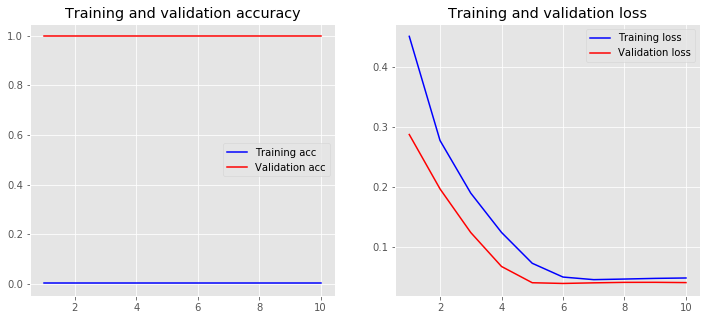

In [31]:
# Plot the graph 
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)


In [32]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

99/99 [==============================] - 5s 51ms/step


In [33]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 6.9%


In [34]:
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      object       0.00      0.00      0.00       128
         unk       1.00      1.00      1.00     49297
       value       0.00      0.00      0.00        75

    accuracy                           1.00     49500
   macro avg       0.33      0.33      0.33     49500
weighted avg       0.99      1.00      0.99     49500



In [35]:
TP = {}
TN = {}
FP = {}
FN = {}
for tag in tag2idx.keys():
    TP[tag] = 0
    TN[tag] = 0    
    FP[tag] = 0    
    FN[tag] = 0    

def accumulate_score_by_tag(gt, pred):
    """
    For each tag keep stats
    """
    if gt == pred:
        TP[gt] += 1
    elif gt != 'O' and pred == 'O':
        FN[gt] +=1
    elif gt == 'O' and pred != 'O':
        FP[gt] += 1
    else:
        TN[gt] += 1
for i, sentence in enumerate(X_test):
    y_hat = np.argmax(test_pred[0], axis=-1)
    gt = np.argmax(y_test[0], axis=-1)
    for idx, (w,pred) in enumerate(zip(sentence,y_hat)):
        accumulate_score_by_tag(idx2tag[gt[idx]],tags[pred])
for tag in tag2idx.keys():
    print(f'tag:{tag}')    
    print('\t TN:{:10}\tFP:{:10}'.format(TN[tag],FP[tag]))
    print('\t FN:{:10}\tTP:{:10}'.format(FN[tag],TP[tag]))
#Reference: https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook

tag:value
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:unk
	 TN:         0	FP:         0
	 FN:         0	TP:     49401
tag:object
	 TN:        99	FP:         0
	 FN:         0	TP:         0


In [ ]:
pd.read_csv(